In [1]:
import pandas as pd
bars = pd.read_csv('data/bars.csv')

In [2]:
bars['ret'] = bars['close'].pct_change()

In [3]:
lookback = 5
bars['past_ret'] = bars['close'].pct_change(lookback)

In [4]:
horizon = 5
bars['future_ret'] = bars['close'].pct_change(horizon).shift(-horizon)

In [5]:
bars = bars.dropna()

In [6]:
bars[['past_ret', 'future_ret']].corr()

,past_ret,future_ret
past_ret,1.000000,0.016948
future_ret,0.016948,1.000000


In [7]:
# dividing the bars into buckets (quantiles)
bars['buckets'] = pd.qcut(bars['past_ret'], 5, labels=False)

In [8]:
average_returns = bars.groupby('buckets')['future_ret'].mean()
average_returns

buckets
0    0.000213
1    0.000199
2   -0.000004
3    0.000318
4    0.000034
Name: future_ret, dtype: float64

<Axes: title={'center': 'Future Return vs Past Return Quantile'}, xlabel='Quantile', ylabel='Average Future Return'>

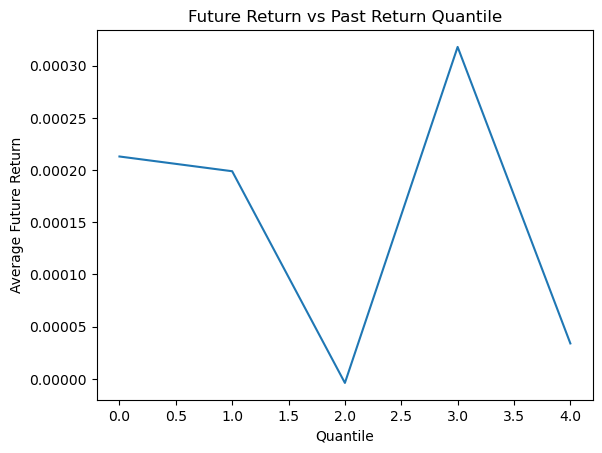

In [9]:
average_returns.plot(title='Future Return vs Past Return Quantile', xlabel='Quantile', ylabel='Average Future Return')

In [10]:
# choosing thresholds for the backtest
upper = bars['past_ret'].quantile(0.8)
lower = bars['past_ret'].quantile(0.2)

In [11]:
bars['pos'] = 0
bars.loc[bars['past_ret'] >= upper, 'pos'] = 1
bars.loc[bars['past_ret'] <= lower, 'pos'] = -1

In [12]:
bars['gross_ret'] = bars['pos']*bars['future_ret']

<Axes: title={'center': 'Equity Curve (without costs)'}, xlabel='Time (minutes)', ylabel='Portfolio Value (start=1)'>

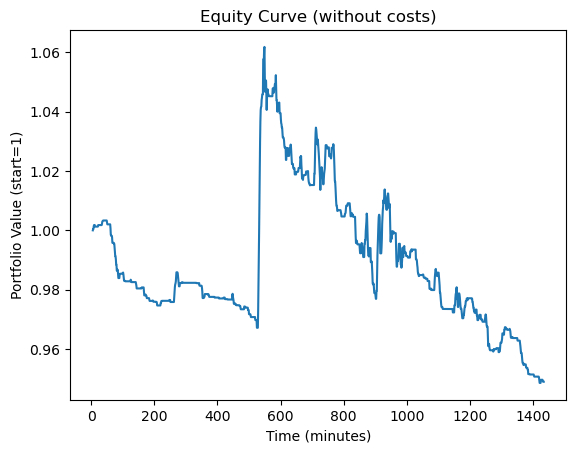

In [13]:
(1 + bars['gross_ret']).cumprod().plot(title='Equity Curve (without costs)', xlabel='Time (minutes)', ylabel='Portfolio Value (start=1)')

In [14]:
bars['gross_ret']

5      -0.000000
6       0.000472
7      -0.000000
8       0.000969
9       0.000351
          ...   
1430    0.000019
1431   -0.000464
1432   -0.000245
1433    0.000000
1434    0.000000
Name: gross_ret, Length: 1430, dtype: float64

In [15]:
len(bars[bars['pos'] != 0])

572

In [16]:
bars['trade'] = bars['pos'].diff().abs()

In [17]:
# assuming the cost per trade is 5bps (based on multiple estimates)
cost = 0.0005

In [18]:
bars['cost'] = bars['trade']*cost

In [19]:
bars['net_ret'] = bars['gross_ret'] - bars['cost']

<Axes: title={'center': 'Cost Adjusted Equity Curve'}, xlabel='Time (minutes)', ylabel='Portfolio Value (start=1)'>

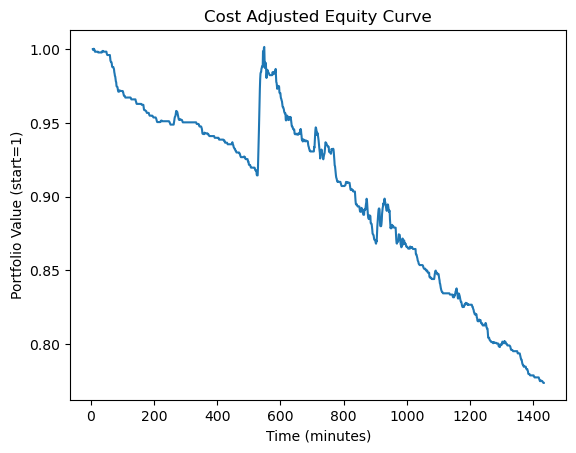

In [20]:
# equity curve
(1+bars['net_ret']).cumprod().plot(title='Cost Adjusted Equity Curve', xlabel='Time (minutes)', ylabel='Portfolio Value (start=1)')

In [21]:
# average net return
bars['net_ret'].mean()

np.float64(-0.00017859584322494352)

In [22]:
# sharpe
bars['net_ret'].mean()/bars['net_ret'].std()

np.float64(-0.13549147992359378)